In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
data = pd.read_csv("cases_state.csv")

In [70]:
data.head()

,date,state,cases_import,cases_new,cases_recovery
0,25/1/2020,Johor,4,4,0
1,25/1/2020,Kedah,0,0,0
2,25/1/2020,Kelantan,0,0,0
3,25/1/2020,Melaka,0,0,0
4,25/1/2020,Negeri Sembilan,0,0,0


In [71]:
data.shape

(9680, 5)

In [72]:
data.dtypes

date              object
state             object
cases_import       int64
cases_new          int64
cases_recovery     int64
dtype: object

In [73]:
# check if any null value is present
data.isnull().values.any()

False

In [74]:
data.isnull().sum()

date              0
state             0
cases_import      0
cases_new         0
cases_recovery    0
dtype: int64

####  Feature Engineering


In [75]:
data['Date']=data['date'].str.split('/').str[0]
data['Month']=data['date'].str.split('/').str[1]
data['Year']=data['date'].str.split('/').str[2]

In [76]:
data.head()

,date,state,cases_import,cases_new,cases_recovery,Date,Month,Year
0,25/1/2020,Johor,4,4,0,25,1,2020
1,25/1/2020,Kedah,0,0,0,25,1,2020
2,25/1/2020,Kelantan,0,0,0,25,1,2020
3,25/1/2020,Melaka,0,0,0,25,1,2020
4,25/1/2020,Negeri Sembilan,0,0,0,25,1,2020


In [77]:
data.dtypes

date              object
state             object
cases_import       int64
cases_new          int64
cases_recovery     int64
Date              object
Month             object
Year              object
dtype: object

In [78]:
data['Date']=data['Date'].astype(int)
data['Month']=data['Month'].astype(int)
data['Year']=data['Year'].astype(int)

In [79]:
data.dtypes

date              object
state             object
cases_import       int64
cases_new          int64
cases_recovery     int64
Date               int32
Month              int32
Year               int32
dtype: object

In [80]:
data=data.drop(['date'],axis=1)

In [81]:
data.head()

,state,cases_import,cases_new,cases_recovery,Date,Month,Year
0,Johor,4,4,0,25,1,2020
1,Kedah,0,0,0,25,1,2020
2,Kelantan,0,0,0,25,1,2020
3,Melaka,0,0,0,25,1,2020
4,Negeri Sembilan,0,0,0,25,1,2020


In [82]:
data.isnull().sum()

state             0
cases_import      0
cases_new         0
cases_recovery    0
Date              0
Month             0
Year              0
dtype: int64

In [83]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
data["state"]=encoder.fit_transform(data['state'])

In [84]:
data.head()

,state,cases_import,cases_new,cases_recovery,Date,Month,Year
0,0,4,4,0,25,1,2020
1,1,0,0,0,25,1,2020
2,2,0,0,0,25,1,2020
3,3,0,0,0,25,1,2020
4,4,0,0,0,25,1,2020


### Feature Selection

In [85]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [87]:
data_train=data[0:10683]
data_test=data[10683:]

In [88]:
X=data_train.drop(['cases_new'],axis=1)
y=data_train.cases_new

In [89]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [90]:
model=SelectFromModel(Lasso(alpha=0.005,random_state=0))

In [91]:
model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [92]:
model.get_support()

array([ True,  True,  True,  True,  True,  True])

In [93]:
selected_features=X_train.columns[(model.get_support())]

In [94]:
selected_features

Index(['state', 'cases_import', 'cases_recovery', 'Date', 'Month', 'Year'], dtype='object')

In [95]:
X_train=X_train.drop(['Year'],axis=1)

In [96]:
X_test=X_test.drop(['Year'],axis=1)

### RandomForestRegressor

In [97]:
from sklearn.model_selection import RandomizedSearchCV
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [98]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [99]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [100]:
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [101]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   1.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_est

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [102]:
y_pred=rf_random.predict(X_test)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cases_new', ylabel='Density'>

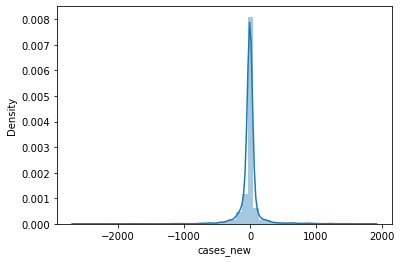

In [103]:
import seaborn as sns

sns.distplot(y_test-y_pred)

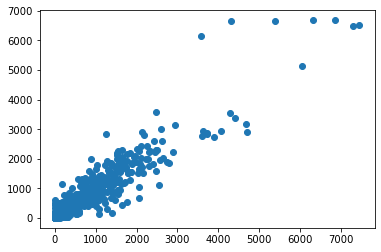

In [104]:
plt.scatter(y_test,y_pred)